In [1]:
%load_ext autoreload
%autoreload 2

# bybitメイカーコスト分析.

- bybitでメイク約定させるときのコストの傾向を把握する.
- メイカーフィー(-2.5bp)込みで、どの程度のコストがかかるかを近似的に計算する.
- テイク約定させるときのコストも計測する.

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import time
from datetime import datetime


## データ読み込み.

### 1分足.

- データはこちらの[秒足作成プログラム](https://github.com/i-love-profit/botter_lab/blob/main/exchange_data/bybit_ohlcv_second.ipynb)で作成. 
- 5秒足や10秒足でより詳細にシミュレーションすることも可能.

In [3]:
symbol = "BTC/USD"
interval = "1m"
bybit_btcusd_1m = pd.read_csv("data/bybit_ohlcv_1min_20210101_20210701.csv")
bybit_btcusd_1m.index = pd.to_datetime(bybit_btcusd_1m["timestamp"], utc=True)
bybit_btcusd_1m

,timestamp,open,high,low,close,volume
timestamp,,,,,,
2021-01-01 00:00:00+00:00,2021-01-01 00:00:00+00:00,28955.0,28984.5,28955.0,28984.5,2720179
2021-01-01 00:01:00+00:00,2021-01-01 00:01:00+00:00,28984.5,29035.0,28984.5,29034.5,5306311
2021-01-01 00:02:00+00:00,2021-01-01 00:02:00+00:00,29035.0,29035.0,29011.5,29011.5,1471654
2021-01-01 00:03:00+00:00,2021-01-01 00:03:00+00:00,29012.0,29017.0,29011.5,29011.5,343817
2021-01-01 00:04:00+00:00,2021-01-01 00:04:00+00:00,29011.5,29014.0,29011.5,29014.0,210728
...,...,...,...,...,...,...
2021-07-01 23:55:00+00:00,2021-07-01 23:55:00+00:00,33580.5,33580.5,33580.0,33580.5,929003
2021-07-01 23:56:00+00:00,2021-07-01 23:56:00+00:00,33580.5,33580.5,33558.0,33558.5,1674578
2021-07-01 23:57:00+00:00,2021-07-01 23:57:00+00:00,33558.0,33558.0,33473.0,33505.0,3625756


## テイカー価格とメイカー価格の付与.

1分足を利用して, テイカー価格とメイカー価格を計算する. 以下で近似する.

**テイカー価格**  
- Open価格に対し, 買い注文の場合は+1tick, 売り注文の場合は-1tickしたものを発注価格とし, 約定価格=発注価格とする.
- 約定価格に対し, テイカーフィーのコスト分だけ不利な価格にずらしたものをテイク価格とする.
- テイク価格はBuy/Sellを別々に計算しておく.


**メイカー価格**  
- Open価格に対し, 買い注文の場合は-1tick, 売り注文の場合は+1tickしたものを発注価格とする.
- 買いの場合, その足の発注価格>Low価格であれば, 発注価格を約定価格とする. そうでない場合, その足では約定しなかったものとし, 次の足のOpenで新たな発注価格で発注し直すものとする.
- 売りの場合, その足の発注価格<High価格であれば, 発注価格を約定価格とする. そうでない場合(ry
- 約定価格が計算されなかった場合, bfillを使って次回以降の足で初めて約定した価格を約定価格とする.
- 約定価格に対し, メイカーフィーのコスト分だけ有利な価格にずらしたものをメイク価格とする.
- メイク価格はBuy/Sellを別々に計算しておく.

※厳密にはOpen時の価格がBuy側約定かSell側約定かが分からない. 長期的にこの誤差は均されるものとする.

In [4]:
tick = 0.5
taker_fee = 0.00075
maker_fee = 0.00025  # マイナス手数料. 下の計算で, メイク価格はこの値を引いて計算される.

bybit_btcusd_1m["taker_buy_price"] = bybit_btcusd_1m["open"] + tick + taker_fee * (bybit_btcusd_1m["open"] + tick)
bybit_btcusd_1m["taker_sell_price"] = bybit_btcusd_1m["open"] - tick - taker_fee * (bybit_btcusd_1m["open"] - tick)
bybit_btcusd_1m["maker_buy_price"] = None
bybit_btcusd_1m.loc[bybit_btcusd_1m["open"] - tick > bybit_btcusd_1m["low"], "maker_buy_price"] = bybit_btcusd_1m["open"] - tick - maker_fee * (bybit_btcusd_1m["open"] - tick)
bybit_btcusd_1m["maker_buy_price"] = bybit_btcusd_1m["maker_buy_price"].fillna(method="bfill")
bybit_btcusd_1m["maker_sell_price"] = None
bybit_btcusd_1m.loc[bybit_btcusd_1m["open"] + tick < bybit_btcusd_1m["high"], "maker_sell_price"] = bybit_btcusd_1m["open"] + tick + maker_fee * (bybit_btcusd_1m["open"] + tick)
bybit_btcusd_1m["maker_sell_price"] = bybit_btcusd_1m["maker_sell_price"].fillna(method="bfill")

bybit_btcusd_1m

,timestamp,open,high,low,close,volume,taker_buy_price,taker_sell_price,maker_buy_price,maker_sell_price
timestamp,,,,,,,,,,
2021-01-01 00:00:00+00:00,2021-01-01 00:00:00+00:00,28955.0,28984.5,28955.0,28984.5,2720179,28977.216625,28932.784125,29027.241375,28962.738875
2021-01-01 00:01:00+00:00,2021-01-01 00:01:00+00:00,28984.5,29035.0,28984.5,29034.5,5306311,29006.738750,28962.262000,29027.241375,28992.246250
2021-01-01 00:02:00+00:00,2021-01-01 00:02:00+00:00,29035.0,29035.0,29011.5,29011.5,1471654,29057.276625,29012.724125,29027.241375,29019.753125
2021-01-01 00:03:00+00:00,2021-01-01 00:03:00+00:00,29012.0,29017.0,29011.5,29011.5,343817,29034.259375,28989.741375,29005.746750,29019.753125
2021-01-01 00:04:00+00:00,2021-01-01 00:04:00+00:00,29011.5,29014.0,29011.5,29014.0,210728,29033.759000,28989.241750,29005.746750,29019.253000
...,...,...,...,...,...,...,...,...,...,...
2021-07-01 23:55:00+00:00,2021-07-01 23:55:00+00:00,33580.5,33580.5,33580.0,33580.5,929003,33606.185750,33554.815000,33571.605000,33514.376500
2021-07-01 23:56:00+00:00,2021-07-01 23:56:00+00:00,33580.5,33580.5,33558.0,33558.5,1674578,33606.185750,33554.815000,33571.605000,33514.376500
2021-07-01 23:57:00+00:00,2021-07-01 23:57:00+00:00,33558.0,33558.0,33473.0,33505.0,3625756,33583.668875,33532.331875,33549.110625,33514.376500


## テイカーコストとメイカーコストの比較.

- コストは, 買い約定のときと売り約定のときの平均をとる.

In [5]:
tmp = bybit_btcusd_1m.copy()
tmp["taker_cost"] = ((tmp["taker_buy_price"] - tmp["open"]) / tmp["open"] - (tmp["taker_sell_price"] - tmp["open"]) / tmp["open"]) / 2
tmp["maker_cost"] = ((tmp["maker_buy_price"] - tmp["open"]) / tmp["open"] - (tmp["maker_sell_price"] - tmp["open"]) / tmp["open"]) / 2
print(f"テイカーコスト平均: {tmp['taker_cost'].mean()*100:.5f}%")
print(f"メイカーコスト平均: {tmp['maker_cost'].mean()*100:.5f}%")


テイカーコスト平均: 0.07615%
メイカーコスト平均: 0.02893%


### メモ.

- 1分足(2021/1/1～2021/7/1)の全平均では, 1分ごとにベスト価格にメイク注文を出したほうが, テイク注文を出すよりも約定コストが小さい.

## メイカーコストの時間帯（分）別の傾向.

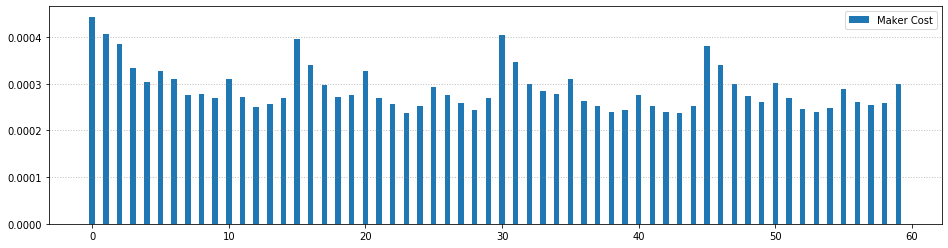

In [6]:
tmp = bybit_btcusd_1m.copy()
tmp["maker_cost"] = ((tmp["maker_buy_price"] - tmp["open"]) / tmp["open"] - (tmp["maker_sell_price"] - tmp["open"]) / tmp["open"]) / 2
tmp["minute"] = tmp.index.minute
tmp = tmp.dropna()
cost = tmp[["minute", "maker_cost"]].groupby("minute").mean()

fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1,1), (0,0))
ax1.grid(which="major", axis="y", color="gray", alpha=0.5, linestyle="dotted", linewidth=1)
ax1.bar(cost.index, cost["maker_cost"], width=0.4, label="Maker Cost")
ax1.legend()
plt.show()

### メモ.

- 分ごとにメイカーコストに傾向が見られる. これはつまるところ分ごとのボラティリティによる.
- メイカーコストは, 00分＞30分＞15分≒45分＞その他.

## 時系列でのメイカーコストの移り変わり.

- 1日ごとのメイカーコスト平均を時系列にプロット.

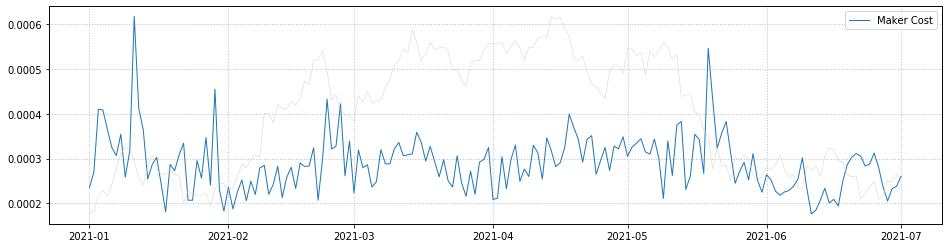

In [7]:
tmp = bybit_btcusd_1m.copy()
tmp["maker_cost"] = ((tmp["maker_buy_price"] - tmp["open"]) / tmp["open"] - (tmp["maker_sell_price"] - tmp["open"]) / tmp["open"]) / 2
tmp = tmp.dropna()

daily = pd.concat([tmp["maker_cost"].resample("1d").mean(), tmp["open"].resample("1d").first()], axis=1)

fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot2grid((1,1), (0,0))
ax1_right = ax1.twinx()
ax1_right.yaxis.set_visible(False)
ax1.grid(which="major", axis="x", color="gray", alpha=0.5, linestyle="dotted", linewidth=1)
ax1.grid(which="major", axis="y", color="gray", alpha=0.5, linestyle="dotted", linewidth=1)
ax1.plot(daily.index.values, daily["maker_cost"], linewidth=1, label="Maker Cost")
ax1_right.plot(daily.index.values, daily["open"], linewidth=0.5, color="lightgray")
ax1.legend()
plt.show()


### メモ.

- もっと長期で見る必要あり.
- 基本的にはボラが激しいとき, メイカーコストは大きくなる.